In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("Projections and signal restoration.ipynb")

# Matrix Analysis 2024 - EE312

## Week 3 - Signal restoration using projections
[LTS2](https://lts2.epfl.ch)

Let us consider a signal with $N$ elements, i.e. a vector in $\mathbb{R}^N$. 
Under our observations conditions, we can only recover partially the signal's values, the other remain unknown, i.e. we know that:

$x[k] = x_k$ for $k\in E = \{e_0, e_1, \dots,e_{M-1}\}$, with $E\in\mathbb{N}^M$ and $e_i\neq e_j \forall i\neq j$ (i.e. each known index is unique).

We also make the assumption that the signal is contained within **lower frequencies of the spectrum**. This can be expressed using the (normalized) Fourier matrix you have constructed last week $\hat{W}$.

In this notebook, we will try to reconstruct the signal by projecting its observation successively on the Fourier subspace defined above, then back to its original domain (with the constraint regarding its values), then on the Fourier domain, etc. This is a simplified version of a more general method called ["Projection onto convex sets" (POCS)](https://en.wikipedia.org/wiki/Projections_onto_convex_sets). The method is illustrated by the figure below (of course you do not project on lines but on spaces having larger dimension).

![POCS](images/pocs.png "POCS")

### 1. Low-pass filter
Let us first create example signals to validate our implementation of the filtering operation.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
N = 100
k = np.arange(0, N)
w1 = 3
w2 = 7
w3 = 12

# generate simple signals
x1 = np.cos(2*w1*np.pi*k/N) + np.sin(2*w2*np.pi*k/N)
x2 = np.sin(2*w1*np.pi*k/N) + np.cos(2*w3*np.pi*k/N)

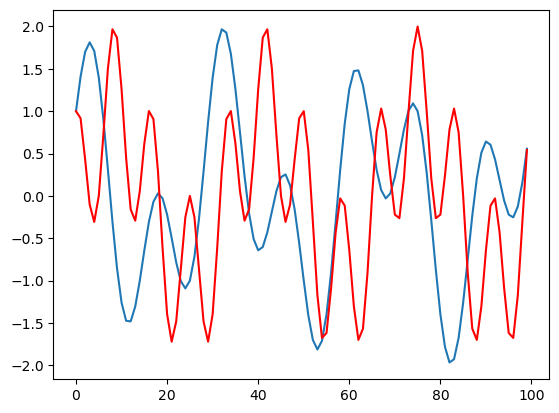

In [3]:
# visualize the base signals
plt.plot(x1)
plt.plot(x2, 'r')

1. Implement a function that returns the normalized Fourier matrix of size N (use your implementation from week 2)

In [4]:
def fourier_matrix(N):
    # BEGIN SOLUTION
    if N <= 0:
        raise ValueError("Invalid size")
    k = np.arange(0, N)
    Ws = np.exp(-2j*np.pi*np.outer(k, k)/N)
    return Ws/np.sqrt(N)
    # END SOLUTION

In [5]:
grader.check("q1")

q1 results: All test cases passed!
q1 - 1 message: Good, your implementation returns correct results
q1 - 2 message: Good, your implementation returns an orthogonal matrix

In [6]:
W_hat = fourier_matrix(N)

Let $X = \hat{W}x$, $X$ is the *discrete Fourier transform* of the input signal $x$. The frequency condition can then be rewritten as 

$X[k] = 0$ for $w_c < k\leq N-w_c$. 

2. Implement the function that returns a $N\times N$ matrix $P$, s.t. $PX$ satisfies the above condition for a given $w_c$. Make sure the input values are valid, if not raise a `ValueError` exception.

In [7]:
def lowpass_matrix(N, w_c):
    """
    Computes the P matrix that will remove high-frequency coefficients in a DFT transformed signal

    Parameters
    ----------
    N : length of the input signal
    w_c : cutoff frequency

    Returns
    -------
    The P matrix
    """
    # BEGIN SOLUTION
    if N < 1:
        raise ValueError("Invalid input size")
    if w_c < 0 or w_c > N//2:
        raise ValueError("Invalid w_c supplied")
    P = np.eye(N)
    P[w_c:N - w_c + 1, w_c:N - w_c + 1] = 0 # be careful with indices, otherwise you end up with a non-real filtered output
    return P
    # END SOLUTION

In [32]:
lowpass_matrix(10, 4)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [8]:
grader.check("q2")

q2 results: All test cases passed!
q2 - 1 message: Good, your implementation returns correct results
q2 - 2 message: Good, you properly validated parameters before computing the result

3. Now let us try the filtering on the test signals and make sure it behaves appropriately. Using the matrix $P$ defined above, choose the parameter $w_c$ approiately s.t. the filtered signals retain $w_1$ and $w_2$ but discard $w_3$.

In [9]:
w_c = 10 # SOLUTION

In [10]:
# Compute the DFT of x1 and x2
X1 = W_hat@x1
X2 = W_hat@x2

# Get the lowpass filter matrix
P = lowpass_matrix(N, w_c)

# Filter X1 and X2 and apply inverse DFT
x1_f = np.real(np.conj(W_hat.T)@P@X1) # SOLUTION
x2_f = np.real(np.conj(W_hat.T)@P@X2) # SOLUTION

NB: Make sure the filtered output is **real** (or its imaginary part should be smaller than $10^{-12}$).

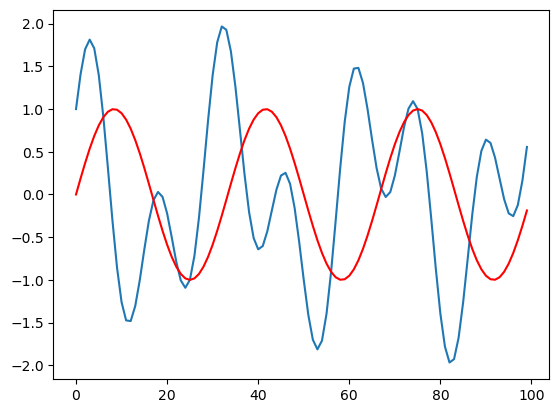

In [11]:
# Plot the filtered signals
# x1_f should still contain both frequencies, x2_f only one
plt.plot(x1_f)
plt.plot(x2_f, 'r')

In [12]:
grader.check("q3")

q3 results: All test cases passed!
q3 - 1 message: Your value of w_c looks correct

<!-- BEGIN QUESTION -->

4. Prove that $P$ is a projection.

_Type your answer here, replacing this text._

$P$ is a projection, since $P^2=P$ (any diagonal matrix with only 0s and 1s on its diagonal would satisfy this)

<!-- END QUESTION -->

### 2. Signal extension

In order to express the condition on $x[k]$ as a pure matrix operation we need to make use of an extension of the input signal and design a slightly different Fourier transform matrix to use properly those extended signals. 

Let us denote by $x_E$ the vector from $\mathbb{R}^M$ containing the known values of $x$, i.e. the $x_k$ for $k\in E$.

For each vector $y$ in $\mathbb{R}^N$ we define its extension as $\tilde{y} = \begin{pmatrix}y \\ x_E\end{pmatrix}$. 

**This notation will remain throughout the notebook**, i.e. a vector with a tilde denotes its extension made by adding the $x_E$ values at the end.

5. Let us define the matrix $B_E$ and $y=B_E x$, s.t. $y[k] = 0$ if $k\in E$ and $y[k] = x[k]$ otherwise. Write a function that returns its extended version $\tilde{B_E}$ s.t. $\tilde{y}=\tilde{B_E}\tilde{x}$, for any $x\in\mathbb{R}^N$. 

- $\tilde{B_E}$ is a square matrix of size $N+M$.
- Check the validity of parameters and raise a `ValueError`  in case of invalid inputs.

In [13]:
def Bt_E(N, E):
    """
    Computes the $\tilde{B}_E$ matrix 

    Parameters
    ----------
    N : length of the input signal
    E : list of suitable indices. e.g. for N=5 a valid E could be [1, 3]

    Returns
    -------
    The $\tilde{B}_E$ matrix 
    """
    # BEGIN SOLUTION
    E = np.unique(E) # remove the duplicates from E
    M = len(E)
    if not np.all(np.array(E)<N):
        raise ValueError("Invalid list of indices supplied")
    if not np.all(np.array(E)>=0):
        raise ValueError("Negative indices supplied")
    if N<1 or M >= N:
        raise ValueError("Invalid dimensions")
        
    B = np.eye((N + M))

    # coefficients on the diagonal having indices in E should be zeroed
    for p in zip(E, E):
        B[p] = 0.
    return B
    # END SOLUTION

In [29]:
Bt_E(5, [1, 3])

array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.]])

In [14]:
grader.check("q5")

q5 results: All test cases passed!
q5 - 1 message: Good, your implementation returns correct results
q5 - 2 message: Good, your implementation returns correct results
q5 - 3 message: Good, you properly validated parameters before computing the result

Let us know design $C_E$ as an operator from $\mathbb{R}^{N+M} \rightarrow \mathbb{R}^{N+M}$ such that when applied to any extended vector $\tilde{z}$ s.t. $\tilde{z}[k] = 0, \forall k\in E$ as input (i.e. for instance the output of $\tilde{B}_E$), it generates a vector $\tilde{z}_R$ s.t.:

$\tilde{z}_R[k] = \left\{\begin{matrix} x_k \mbox{ if } k\in E \\ \tilde{z}[k] \mbox{ otherwise} \end{matrix}\right.$

6. Write a function that generates $C_E$. 

In [15]:
def C_E(N, E):
    """
    Computes the $C_E$ matrix 

    Parameters
    ----------
    N : length of the input signal
    E : list of suitable indices. e.g. for N=5 a valid E could be [1, 3]

    Returns
    -------
    The $C_E$ matrix 
    """
    # BEGIN SOLUTION
    E = np.unique(E) # remove the duplicates from E
    M = len(E)
    if not np.all(np.array(E)<N):
        raise ValueError("Invalid list of indices supplied")
    if not np.all(np.array(E)>=0):
        raise ValueError("Negative indices supplied")
    if N<1 or M >= N:
        raise ValueError("Invalid dimensions")
        
    C = np.eye(N+M)
    for p in zip(range(M), E):
        C[p[1], N+p[0]] = 1.
    return C
    # END SOLUTION

In [30]:
C_E(5, [1, 3])

array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.]])

In [16]:
grader.check("q6")

q6 results: All test cases passed!
q6 - 1 message: Good, your implementation returns correct results
q6 - 2 message: Good, you properly validated parameters before computing the result

<!-- BEGIN QUESTION -->

7. What is the effect of $D_E = C_E \tilde{B}_E$ on an extended signal $\tilde{x}$ ? 

_Type your answer here, replacing this text._

The effect of $D_E$ is to replace values by the known initial values.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

8. Verify (numerically on an example) that $D_E$ is a projector. You can use the function `numpy.testing.assert_array_almost_equal` to check that arrays are almost equal (with a good precision)

In [17]:
# Set some parameters
N=5
E=[1,3]
# Compute D_E
D_E = C_E(N, E)@Bt_E(N, E) # SOLUTION
# Now check that D_E is a projector
# BEGIN SOLUTION
np.testing.assert_array_almost_equal(D_E@D_E - D_E, np.zeros(D_E.shape))
# END SOLUTION

<!-- END QUESTION -->

### 3. Extended signals in the Fourier domain
Let us now define an operator that will work almost as the normalized Fourier transform, except that it will be applied to the extended signals and preserve the $x_E$ part. This can be easily done using the following block matrix:

$\tilde{W} = \begin{pmatrix}\hat{W} & 0 \\0 & I_M\end{pmatrix}$.


Using this definition, multiplying an extended signal $\tilde{x}$ by $\tilde{W}$ will result in a vector containing the Fourier transform of $x$ followed by $x_E$, preserving the known initial values.

<!-- BEGIN QUESTION -->

9. Prove that $\tilde{W}$ is orthonormal. 

_Type your answer here, replacing this text._

$\tilde{W}$ is orthonormal: it is block-diagonal and each block is orthonormal. It is then fairly easy to check that $\tilde{W}\tilde{W}^H=I$. 

<!-- END QUESTION -->

10. Write a function that returns $\tilde{W}$.

In [18]:
def Wt_E(N, E):
    """
    Computes the $\tilde{W}_E$ matrix 

    Parameters
    ----------
    N : length of the input signal
    E : list of suitable indices. e.g. for N=5 a valid E could be [1, 3]

    Returns
    -------
    The $\tilde{W}_E$ matrix 
    """
    # BEGIN SOLUTION
    E = np.unique(E) # remove the duplicates from E
    M = len(E)
    if not np.all(np.array(E)<N):
        raise ValueError("Invalid list of indices supplied")
    if not np.all(np.array(E)>=0):
        raise ValueError("Negative indices supplied")
    if N<1 or M >= N:
        raise ValueError("Invalid dimensions")
        
    W_hat = fourier_matrix(N)
    W_tilde = np.zeros((N+M, N+M), dtype=complex)
    W_tilde[:N, :N] = W_hat
    W_tilde[N:, N:] = np.eye(M)
    return W_tilde
    # END SOLUTION

In [19]:
grader.check("q10")

q10 results: All test cases passed!
q10 - 1 message: Good, your implementation returns correct results
q10 - 2 message: Good, you properly validated parameters before computing the result

11. Recalling the low-pass matrix $P$ defined previously, build $\tilde{P}$ s.t. when applied to $\tilde{W}\tilde{x}$ it results in a vector containing the filtered values (still in the Fourier domain) followed by $x_E$.

In [20]:
def Pt_E(N, M, w_c):
    # BEGIN SOLUTION
    P = np.eye(N+M) # initialize with an all-pass filter
    P[:N, :N] = lowpass_matrix(N, w_c)
    return P
    # END SOLUTION

<!-- BEGIN QUESTION -->

12. A signal $\tilde{x}$ will be filtered by doing $\tilde{W}^H \tilde{P}\tilde{W}\tilde{x}$.
Prove that this is a projection.

_Type your answer here, replacing this text._

$\tilde{W}^H \tilde{P}\tilde{W}$ is a projection since

$\tilde{W}^H \tilde{P}\tilde{W}\tilde{W}^H \tilde{P}\tilde{W} = \tilde{W}^H \tilde{P}\tilde{P}\tilde{W}$ (grouping the middle term $\tilde{W}\tilde{W}^H=I$)

Since $\tilde{P}$ is a projection, this is equal to $\tilde{W}^H \tilde{P}\tilde{W}$.


<!-- END QUESTION -->

### 4. Signal restoration

<!-- BEGIN QUESTION -->

13. We can now use all defined above to implement a function that performs an iteration, taking as input the extension of $x$ as defined above, that does the following:
- compute the filtered version of the signal using $\tilde{W}^H \tilde{P}\tilde{W}$ (i.e. projecting on the space of "smooth signals")
- restore the known values in the signal by using $D_E = C_E\tilde{B}_E$ (i.e project back on the space of signals having the known initial values we have set)

Make sure to force the result to real values by using `np.real` before returning

In [21]:
def restoration_iter(Wt, Pt, Dt, xt):
    """
    Performs a full restoration iteration by
    - projecting the signal into Fourier, performing low-pass filtering followed by inverse DFT
    - restoring the known initial values into the filtered signal

    Parameters
    ----------
    Wt : \tilde{W} matrix
    Pt : \tilde{P} matrix
    Dt : \tilde{D} matrix
    xt : \tilde{x} vector

    Returns
    -------
    The new $\tilde{x} vector after the iteration
    """
    # BEGIN SOLUTION
    # project in fourier
    X = Wt@xt
    # filter and inverse DFT
    z = np.conjugate(Wt.T)@(Pt@X)
    
    # restore known values
    xr = Dt@z
    return np.real(xr)
    # END SOLUTION

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

15. Finally we are ready to apply all this to an example.

In [22]:
# Setup an example
N = 100
w_c = 10 # cut-off
w1 = 3
w2 = 7
E =  np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95])
# E =  np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90]) # try with less known points
M = len(E)
x = np.cos(2*w1*np.pi*np.arange(0, N)/N) + np.sin(2*w2*np.pi*np.arange(0,N)/N) # original signal

# Create a signal that is only noise, except at known initial values
y = np.random.rand(N) # 
y[E] = x[E] # restore known values
xe = x[E]

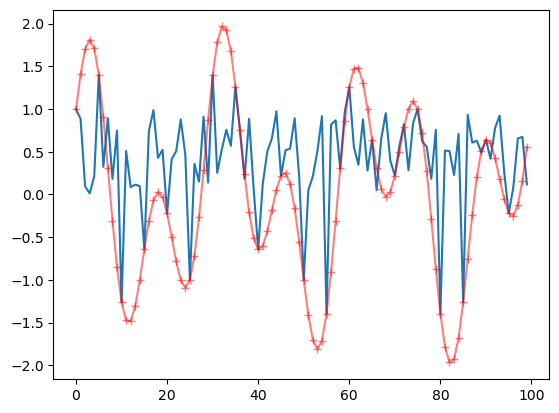

In [23]:
plt.plot(y) # plot the "acquired" signal
plt.plot(x, 'r+-', alpha=0.5) # plot the ground truth signal

Generate $\tilde{y}$ (this only need to be done once)

In [24]:
yt = np.append(y, xe) # SOLUTION

Run a number of iterations of the method and plot the result:

In [25]:
def signal_restore(Wt, Pt, Dt, yt, niter=20):
    yr0 = yt # initialize
    for k in range(niter):
        yr1 = restoration_iter(Wt, Pt, Dt, yr0)
        yr0 = yr1
    return yr1

In [26]:
Wt = Wt_E(N, E)
Dt = C_E(N, E)@Bt_E(N, E)
Pt = Pt_E(N, M, w_c)
yr = signal_restore(Wt, Pt, Dt, yt)

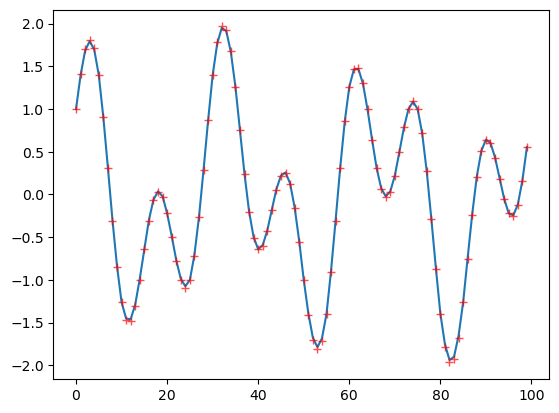

In [27]:
plt.plot(yr[:N]) # plot reconstructed signal
plt.plot(x, 'r+', alpha=0.7) # plot original for comparison

Depending on $M$, you will find that the method can reconstruct perfectly the signal or not.  

<!-- END QUESTION -->



## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [28]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=True)

Running your submission against local test cases...


Your submission received the following results when run against available test cases:

    q1 results: All test cases passed!
    q1 - 1 message: Good, your implementation returns correct results
    q1 - 2 message: Good, your implementation returns an orthogonal matrix

    q2 results: All test cases passed!
    q2 - 1 message: Good, your implementation returns correct results
    q2 - 2 message: Good, you properly validated parameters before computing the result

    q3 results: All test cases passed!
    q3 - 1 message: Your value of w_c looks correct

    q5 results: All test cases passed!
    q5 - 1 message: Good, your implementation returns correct results
    q5 - 2 message: Good, your implementation returns correct results
    q5 - 3 message: Good, you properly validated parameters before computing the result

    q6 results: All test cases passed!
    q6 - 1 message: Good, your implementation returns correct results
    q6 